<a href="https://colab.research.google.com/github/Nick7900/glhmm_protocols/blob/main/Procedures/Procedure_2_Across_trials_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procedure 2: Across-trials testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)

In this tutorial, we explore how to implement across-trials testing using the [GLHMM toolbox](https://github.com/vidaurre/glhmm). Details about the HMM and the different models can be found in the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python). This test is intended to assess differences in the signal between trial labels (experimental conditions, stimuli, subject actions...) 

For this example, we use data collected from a **single participant** performing a *n*-back memory task during **Magnetoencephalography (MEG)** scanning. The participant completed the task over **15 sessions** spanning ~6 months. In each session, the subject passively viewed images that could be animate vs. inanimate. The tutorial focuses on data from the occipital region of the brain (72 channels) and looks at patterns of activity in the alpha band (8-13 Hz). However, this analysis has also been run on other bands, e.g. delta-theta (1-8 Hz), beta (13-30 Hz) and gamma band (30-40 Hz). To analyse a different frequency band, update the `freqs` and `band_name` parameters in Step 3.

---

### Objective of this Procedure
The key question we aim to answer is: 
 
**“Do the subject's brain states significantly differ between experimental conditions across trials?”**

To address this, we will:
* Estimate brain states: Train a Hidden Markov Model (HMM) to decode brain states from the MEG data for all sessions.
* Test the relation between the states activations and the identity of the stimulus, time point by time point using permutation testing.

Note that the standard practice in the field is to run a similar test like this (or alternative, out-of-sample prediction) on the raw signal. The difference of doing it with the HMM state time courses is that, depending on the choice of the state probability distribution, we can test differences in higher order features such as connectivity. 


---

### Relationship to other Procedures

Steps 1–5 in this procedure are identical to those in **Procedure 3**, since both procedures use the same dataset and preprocessing steps.  
However, the **research focus** differs.

- **Procedure 2 (this tutorial)** tests variability **across trials**.
- **Procedure 3** tests the variability **across sessions**.

---

### Structure of the Procedure
The steps in this tutorial follow the workflow shown in the figure below:

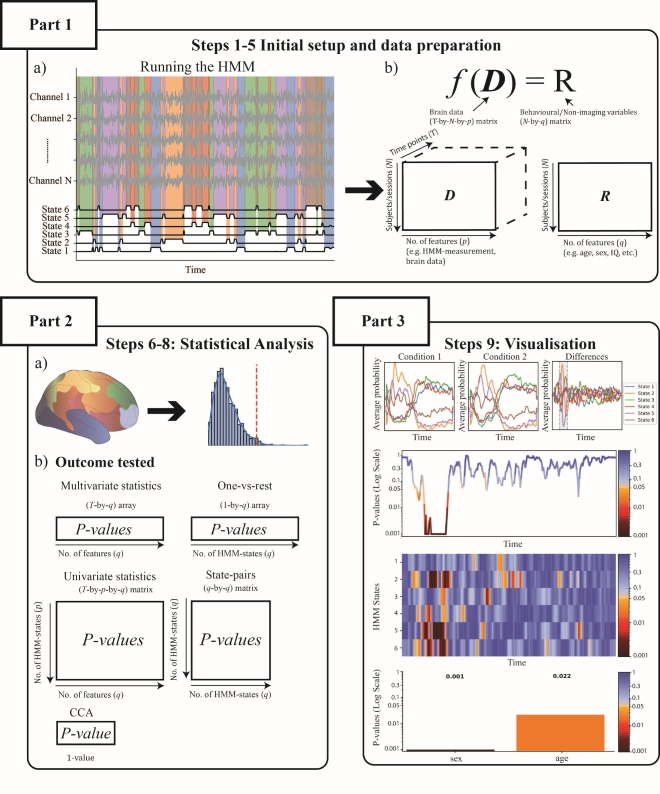

### Table of Contents
* [Part 1. Load and prepare data](#load-data)
    * [Step 1. Load data into Python environment](#prep_env)
    * [Step 2. Data structuring for the HMM](#data_shape)
    * [Step 3. Preprocessing data](#preprocess_data)
    * [Step 4. Set-up and train HMM](#data_handle1)
    * [Step 5. Configure HMM outputs for statistical analysis](#data_handle)
* [Part 2 & 3. Statistical Analysis and Visualisation](#stat_analysis)
    * [Step 6. Types of test - Across trials test](#stat_test)
    * [Step 7. Multivariate test](#multi_test)
        * [Step 8. Multiple comparison test - Multivariate](#multi_corr)
        * [Step 9. P-value plots - Multivariate](#multi_vis)
    * [Step 7. Univariate test](#uni_test)
        * [Step 8. Multiple comparison test - Univariate](#uni_corr)
        * [Step 9. P-value plots - Univariate](#uni_corr2)
    * [Extra - FWER Correction](#uni_test3)

  

### Install necessary packages
If you dont have the **GLHMM-package** installed or using **Google Colab**, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```

### Import libraries
Let's start by importing the required libraries and modules.

In [16]:
# Install the GLHMM_package when using Google Colab
try:
    import google.colab
    IN_COLAB = True
    !pip install git+https://github.com/vidaurre/glhmm
except ImportError:
    IN_COLAB = False

# Import libraries
import numpy as np
from glhmm import io,glhmm, graphics, statistics, preproc
from pathlib import Path
import pickle

## Part 1. Initial setup and data preparation <a id="load-data"></a>
### Step 1. Load data into Python environment <a id="prep_env"></a>

The data we are using is stored in the folder `data_MEG`. It includes brain activity recordings (`D_raw`), behavioural labels (`R_data`), and event information (`event_data`). Each dataset plays an important role in analysing how the brain responds during different trials.


In [7]:
# Define the working directory and the target data path
PATH_WORKING = Path.cwd()
PATH_DATA = PATH_WORKING / "data" / "Procedure_2_and_3_data"
PATH_FIGURES = PATH_DATA / "figures"
PATH_HMM_DATA = PATH_DATA / "data_HMM"

# If the required data for the protocol paper is missing, this function downloads it from Zenodo.
io.prepare_data_directory(PATH_DATA)

# Load brain activity data
with open(PATH_DATA / "D_raw.pkl", "rb") as f:
    D_raw = pickle.load(f)

# Load behavioural data
with open(PATH_DATA / "R_data.pkl", "rb") as f:
    R_data = pickle.load(f)

# Load event data
with open(PATH_DATA / "event_markers.pkl", "rb") as f:
    event_markers = pickle.load(f)

# Display data information
print(f"Number of sessions in D_raw: {len(D_raw)}")
print(f"Number of trials in R_data: {len(R_data)}")
print(f"Number of event records in event_markers: {len(event_markers)}")

Number of sessions in D_raw: 15
Number of trials in R_data: 15
Number of event records in event_markers: 15


#### Explore the Dataset
This data set, specifically, comprises of brain activity (`D_raw`), behavioural measurements (`R_data`), and event information (`event_markers`).

**Brain Data (`D_raw`)**\
The brain data is a list of 15 recordings, where each recording captures continuous brain activity from an entire session. Each session is stored as a 2D matrix `(No. of timepoints, No. of channels)`:
- Timepoints: Represent all recorded time points in the session.  
- Channels:  72 selected occipital channels in sensor space.


**Behavioural Measurements (`R_data`)**  
The behavioural data is a list of 15, where each element represents a session. Each element is a 1D array, where:
- Length of the array: Matches the number of trials within the session.  
- Labels: Each trial is labelled as animate (`1`) or inanimate (`0`), based on the visual stimuli presented.

**Event Data (`event_markers`)**  
The event markers file is used to segment (epoch) the brain recordings (`D_raw`) into trials matching the labels in `R_data`. It includes 15 entries, one for each session, and each entry is a 2D table where each row represents a trial:
- Start time: The specific time in the brain recording (`D_raw`) when the trial begins.  
- Condition: Consistently `0` because the same trial type is used throughout the dataset. 
- Event code: A number identifying the type of event.

We only use the start time (first column) from the event markers for epoching, but we kept the original file structure so the data compatible with tools like MNE.


### Step 2. Data structuring for the HMM <a id="data_shape"></a>
To train the HMM, the brain activity data needs to be structured as a 2D matrix. This involves concatenating all MEG sessions (`D_raw`) along the time dimension. The resulting matrix, referred to as `D_con`, has the shape ```[Total No. of timepoints across all trials, No. of channels]```. 

In addition to `D_con`, we need an index matrix to track the start and end timepoints for each session in the concatenated data. This matrix, referred to as `idx_data`, has the shape of ```[No. of subjects, 2]```.
Each row of the matrix specifies the start and end timepoints for a session. This step is important for the HMM to know where each session begins and ends.

To create the index matrix, we use the `get_indices_from_list` function from the statistics module. This function extracts the boundaries directly from the original `D_raw` structure.


In [8]:
# Concatenate all MEG sessions into a single dataset
D_con = np.concatenate(D_raw, axis=0) if IN_COLAB==False else statistics.get_concatenate_data_memmap(D_raw)

# Get the start and end indices for each session
idx_data = statistics.get_indices_from_list(D_raw)
del D_raw

# Display the shapes of the resulting structures
print(f"Shape of concatenated data (D_con): {D_con.shape}")
print(f"Shape of index matrix (idx_data): {idx_data.shape}")
print(f"Indices for each session:\n {idx_data}")

Shape of concatenated data (D_con): (10864515, 72)
Shape of index matrix (idx_data): (15, 2)
Indices for each session:
 [[       0  1530001]
 [ 1530001  3034002]
 [ 3034002  3768503]
 [ 3768503  4518504]
 [ 4518504  4881505]
 [ 4881505  5644506]
 [ 5644506  6398507]
 [ 6398507  6766508]
 [ 6766508  7504509]
 [ 7504509  7872510]
 [ 7872510  8626511]
 [ 8626511  9385512]
 [ 9385512  9750513]
 [ 9750513 10496514]
 [10496514 10864515]]


**Reviewing the data structure**

After structuring the data, it is helpful to inspect the shapes of `D_con` and `idx_data`:

- `D_con`: The concatenated dataset has the shape `(10864515, 72)`, corresponding to the total number of timepoints across all sessions and the 72 MEG channels.
- `idx_data`: The index matrix aligns with the 15 sessions and indicates the start and end timepoints for each session in `D_con`. For example, the first row might show `[0, 1530001]`, representing the time range for the first session.

### Step 3. Preprocessing data <a id="preprocess_data"></a>

Before we can train the HMM, we need to prepare the MEG data so it is ready for analysis.
However, **preprocessing and training the HMM are optional**. If you prefer, you can skip these steps and use the pre-saved `Gamma` values provided for this tutorial (see **Step 4**). The `Gamma` values, obtained from the HMM, represent the probabilities of being in each brain state at every timepoint and are central to the subsequent analysis.

For those who want to train the HMM themselves, the preprocessing steps are as follows:

---
#### Preprocessing Steps:
* *Filtering the Data:* We apply a band-pass filter to isolate activity within a frequency band of interest, in this example, the *alpha band* (8-13 Hz). 
* *Hilbert transform:* We will apply the Hilbert transform to get the amplitude of the alpha wave per time point.
* *Principal Component Analysis (PCA):* To reduce complexity, we retain 90% of the data variance using PCA. This simplifies the data and makes it faster to process.

For this tutorial, we focus on the **alpha band** as an example, but the same steps can be applied to other bands.

In [9]:
# Define frequency bands and settings
band_name = "alpha"
freqs = (8, 13)  # Frequency range for band
pca_variance = 0.9  # Retain 90% of variance in PCA
fs = 1000  # Original sampling rate of the data
onpower = True  # Use Hilbert transform for amplitude and phase
f_target = 250  # Downsample to 250 Hz
K = 5  # Number of HMM states

**Preprocessing the Data**:
* ⚠️ **Cannot** preprocess or train the HMM on Google Colab due to memory constraints (Colab provides ~12GB in the free tier).  
* ➡️ Skip this step and go to **Step 4** to load pre-trained Gamma values instead.

In [ ]:
# Preprocess the data
data_session_preproc, idx_data_preproc = preproc.preprocess_data(
    data=D_con,
    indices=idx_data,
    fs=fs,
    standardise=True,  # Standardise the data
    filter=freqs,  # Apply band-pass filter
    onpower=onpower,  # Apply Hilbert transform
    pca=pca_variance,  # PCA to reduce dimensionality
    downsample=f_target  # Downsample to target frequency
)

### Step 4. Set-up and train a HMM <a id="data_handle1"></a>

The HMM estimates recurring patterns in brain activity over time. It identifies "states" in the data, i.e. periods of time during which the data show relatively stable properties. 

One of the main results of training the HMM is the state time courses, referred to as `Gamma`. This is the probability of each state to be active per timepoint. Gamma will be the focus of our subsequent analysis.

---

**Option 1: Skip Training with pre-saved `Gamma` values**
Before training the HMM, you can choose to load pre-saved (`Gamma`) to skip the training process entirely. This lets you use the state time courses from this tutorial directly. To load pre-saved results for the **alpha band**:

```python
# Run this to load pre-saved HMM results instead!
band_name = "alpha"
Gamma = np.load(PATH_HMM_DATA / f"Gamma_group_{band_name}.npy")
idx_data = np.load(PATH_HMM_DATA / f"idx_data_{band_name}.npy")

```
---

**Option 2: Train the HMM**\
If you have preprocessed the data yourself, you can train the HMM to estimate `Gamma`. 

**Set up the model**\
For this tutorial, we use a standard Gaussian HMM. Here are the settings we use:
* `model_beta='no'`: No interaction modeling between variable sets.
* `K=5`: Number of brain states to identify (you can adjust this number as needed).
* `covtype='full'`: Each state uses a full covariance matrix.

(See the [GLHMM paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python) for details about all the possible models)

**Train the model**\
The preprocessed MEG data (`data_session_preproc`) filtered to include only alpha band activity is the input (`Y`), and session indices (`idx_data_preproc`) marks the beginning and end  of each preprocessed session. As this is a standard HMM without interactions between variable sets, we set ```X=None```.


In [56]:
# Set up the model
hmm_classic = glhmm.glhmm(model_beta='no', K=K, covtype='full')

# Train the HMM
Gamma, _, _  = hmm_classic.train(X=None, Y=data_session_preproc, indices=idx_data_preproc)

/home/nick/.conda/envs/GLHMM_env/lib/python3.9/site-packages/glhmm/auxiliary.py:241: RuntimeWarning: invalid value encountered in divide
  a[t,:,:] = a[t,:,:] / xp.expand_dims(sc[t,:],axis=1)


Init repetition 1 free energy = -9472834.479124062
Init repetition 2 free energy = -9407856.16281041
Init repetition 3 free energy = -9368932.5326355
Init repetition 4 free energy = -9433549.816263184
Init repetition 5 free energy = -9397311.7044083
Best repetition: 1
Cycle 1 free energy = -9474040.757947966
Cycle 2 free energy = -9486220.524228176
Cycle 3, free energy = -9490256.289395953, relative change = 0.24888269500890825
Cycle 4, free energy = -9493291.008657195, relative change = 0.15764570067585082
Cycle 5, free energy = -9495863.217759922, relative change = 0.1178698059197826
Cycle 6, free energy = -9498153.023194522, relative change = 0.09496434329937753
Cycle 7, free energy = -9500056.816868344, relative change = 0.07317763538471433
Cycle 8, free energy = -9501590.08920394, relative change = 0.05565551923384284
Cycle 9, free energy = -9502804.303959852, relative change = 0.04221366709826543
Cycle 10, free energy = -9503781.563694866, relative change = 0.03285922188292279
Cy

Once the HMM training is complete, it provides three outputs that summarize the brain's state dynamics and the model's performance:

- **`Gamma`**: One probability per state and time point. 

- **`Xi`**: The joint probability of each pair of states being active for every pair of consecutive time points. 

- **`FE`**: A measure of how well the model fits the data (smaller values mean a better fit).

While the model is training, you'll see updates showing how the fit (`FE`) improves with each step.

### Step 5. Configure HMM outputs for statistical analysis <a id="data_handle"></a>

Now that we have the `Gamma` values from the HMM, we can study how these brain states relate to specific events in the data. Let’s start by taking a look at the shape of the data

In [11]:
print(f"Data dimension of 'data_con': {D_con.shape}")
print(f"Data dimension of 'Gamma': {Gamma.shape}")
del D_con

Data dimension of 'data_con': (10864515, 72)
Data dimension of 'Gamma': (2716140, 5)


The original data has 10864515 timepoints and 72 MEG channels, reduced after processing to 2716140 time points.
Gamma has 2716140 timepoints and 5 brain states.


**Epoch the data**\
To analyse brain responses to specific events, such as when a stimulus is presented, we divide the data into smaller time segments, or epochs. For each trial, we use an event file that marks when a stimulus was shown. Since the data has already been downsampled from 1000 Hz to 250 Hz, we need to adjust the timestamps inside the `event_markers` so they match the downsampled `Gamma` data.

In [12]:
fs_target= 250 # Define the target sampling frequency
epoch_window_tp = 250 # Set the epoch window length in timepoints

# Iterate over each frequency band in the data dictionary
gamma_epoch, idx_data_epoch, R_data_epoch = statistics.get_event_epochs(
    Gamma,                              # HMM state time courses
    idx_data,                           # Session indices
    R_data,                             # Additional data
    event_markers,                      # Event markers
    fs=fs,                              # Original sampling frequency
    fs_target=fs_target,                # Downsampled frequency
    epoch_window_tp=epoch_window_tp     # Epoch window length 
)
del Gamma, event_markers

# Check the dimensions of the extracted data
print(f"Shape of gamma_epoch (D): {gamma_epoch.shape}")
print(f"Shape of R_data_epoch (R): {R_data_epoch.shape}")
print(f"Indices for each session:\n {idx_data_epoch}")

Shape of gamma_epoch (D): (250, 8368, 5)
Shape of R_data_epoch (R): (8368,)
Indices for each session:
 [[   0 1162]
 [1162 2307]
 [2307 2875]
 [2875 3456]
 [3456 3741]
 [3741 4322]
 [4322 4905]
 [4905 5197]
 [5197 5767]
 [5767 6056]
 [6056 6635]
 [6635 7213]
 [7213 7502]
 [7502 8076]
 [8076 8368]]


The outputs are: 

* `gamma_epoch`: This contains the epoched Gamma data for each trial, with dimensions [No. of time points, No. of trials, No. of states]. For example:

    - In this example, `gamma_epoch` has dimensions (250, 8368, 5), meaning 250 time points per trial, 8368 trials, and 5 states.
* `R_data_epoch`: This array contains information about the stimulus type for each trial. In our case:
    - `0` indicates an inanimate object.
    - `1` indicates an animate object.
* `idx_data_epoch`: This matrix marks the start and end trial indices for each session. Each row corresponds to one session, and the two numbers in each row represent: 
    - Start Index: The trial number where the session begins.
    - End Index: The trial number where the session ends (non-inclusive).



**Visualise brain state probabilities**\
Before running the statistical tests, we can visualize how the brain’s state probabilities differ between the two contrasts (e.g., inanimate vs. animate). By plotting the average probability for each state over time, we can get a sense of how the brain's activity, as represented by the states, differs between contrasts. This is a *state-evoked response*.

Here we show the average probability of each state over time for inanimate (0) and animate (1), and the difference in probabilities between the two contrasts.


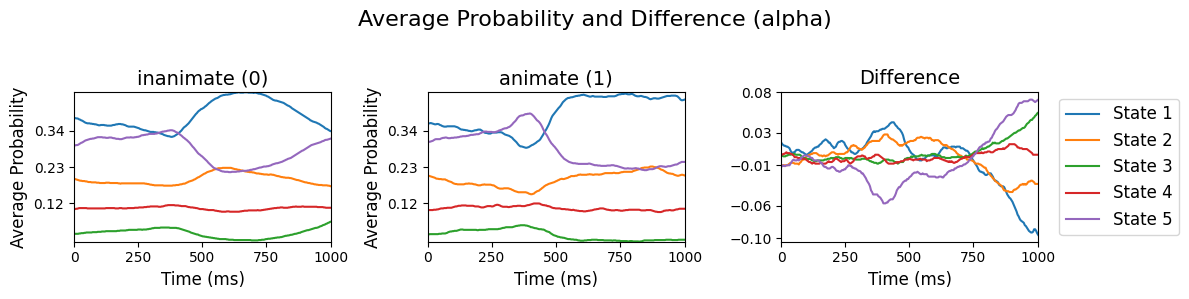

In [14]:
# Load the Gamma values
condition_labels=('inanimate (0)', 'animate (1)')

# Plot the average probability and differences
graphics.plot_condition_difference(
    gamma_epoch, 
    R_data_epoch,
    condition_labels=condition_labels,
    title=f"Average Probability and Difference ({band_name})",
    x_tick_min=0, 
    x_tick_max=1000, 
    num_x_ticks=5,
    xlabel="Time (ms)"
)


## Part 2 & 3 - Statistical Analysis and visualisation <a id="stat_analysis"></a>

### Step 6. Types of test - Across-trials test <a id="stat_test"></a>
With the `gamma_epoch` matrix representing brain data ($D$) and the `R_data_epoch` containing behavioural measurements ($R$) indicating whether an object was animate or inanimate, we can now perform statistical tests to study their relationships using the function `test_across_trials`.
This test is designed to analyse variability across trials within a session. In our case, this speaks to how differently are the brain responses (evoked brain states) when shown animate objects versus inanimate ones.

Instead of assuming a specific data distribution, permutation testing assesses statistical significance by creating a "null distribution" in a non-parametric fashion. For this, it randomly shuffles the data to simulate a scenario where no relationship exists between the variables tested (the null hypothesis). For `test_across_trials`, each observation corresponds to a trial within the same session. By comparing the original data's effect size with the null distribution, we can determine whether the observed differences are statistically significant (the alternative hypothesis).


This process is visualised in **Figure 5B** from the [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4):

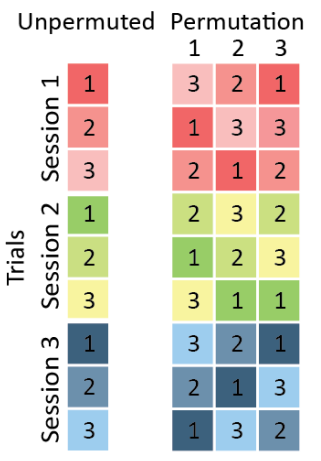

A 9 x 4 matrix representing permutation testing across trials. Each number corresponds to a trial within a session, and permutations are performed within sessions.
The first column: displays the original index of each trial (perm=0). Next columns: examples of permuted trial indices.

### Step 7. Multivariate Test <a id="multi_test"></a>


Building on the concept of permutation testing, the multivariate analysis aims to evaluate whether the state time courses of our brain data ($D$, represented by ```Gamma_epoch```) are associated to experimental conditions ($R$, represented by ```R_data_epoch```), here inanimate versus animated stimuli. This approach considers all states simultaneously.

---

##### Inputs and Settings

To perform the multivariate analysis using the `test_across_trials` function, the following inputs and settings are defined:

**Inputs:**
* ```D_data```: The state time courses of the brain data (```gamma_epoch```).
* ```R_data```: The experimental conditions or subject actions (```R_data_epoch```).
* ```idx_data``` : Indices for the first and last trial for a given session (```idx_data_epoch```)

**Settings:**
* ```method = "multivariate"```: Specifies that the test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).
---

The```test_across_trials``` function returns a dictionary, here called `results_multivariate`, which will contain the output for the selected frequency band:



In [ ]:
# Set parameters for multivariate testing
method = "multivariate"
Nperm = 10_000  # Number of permutations
test_statistics_option = True

# Perform across-trial testing
results_multivariate = statistics.test_across_trials(
    D_data=gamma_epoch,
    R_data=R_data_epoch,
    idx_data=idx_data_epoch,
    method=method,
    Nperm=Nperm,
)

performing permutation testing per timepoint


100%|██████████| 250/250 [20:41<00:00,  4.96s/it]


We can now examine the ```result_multivariate``` variable. Significant results indicate that the Gamma values contribute to explaining differences in stimuli contrasts, while non-significant results suggest there are none.

* ```pval```: the p-values resulting from the permutation test. Each value corresponds to a behavioural variable and will have shape of 1 by q (representing one contrast).

* ```base_statistics```:  the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```:  by default  a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```test_type```: the type of permutation test performed. In this case, it is ```test_across_trials```

* ```method```:  the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing

* ```test_combination```  whether p-values are combined. This can be done across rows (producing one p-value per row), across columns (producing one p-value per column), or into a single combined p-value for the entire matrix

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```performed_tests```: A dictionary that marks the columns in the test_statistics or p-value matrix corresponding to the (q dimension) where t-tests or F-tests have been performed

* ```Nperm```:  the number of permutations that has been performed

* ```test_summary```: A dictionary summarising the test results based on the applied method.

We can also show the test summary of our test using the function `display_test_summary` for the first timepoint

In [53]:
statistics.display_test_summary(results_multivariate, timepoint=0)


Model Summary (timepoint 0):
    Outcome     R²  F-stat  df1  df2  p-value (R²)
Regressor 1 0.0003  0.5337    5 8363        0.2905

Coefficients Table (timepoint 0):
Predictor     Outcome    T-stat  p-value      LLCI     ULCI
  State 1 Regressor 1 -0.643101 0.411641 -1.633044 1.365898
  State 2 Regressor 1  0.897008 0.143114 -1.222491 1.180396
  State 3 Regressor 1 -0.317637 0.682968 -1.477816 1.565176
  State 4 Regressor 1 -0.238778 0.663166 -0.999320 1.147828
  State 5 Regressor 1  0.831792 0.304330 -1.648533 1.563901


#### Step 8. Multiple Comparison - Multivariate <a id="multi_corr"></a>

To reduce the risk of false positives (type I errors) in the multivariate test, we can apply two types of corrections to the p-values from the `results_multivariate` output:

* Benjamini/Hochberg Correction: This method adjusts p-values to control for false discovery rates. This uses the `pval_correction` function, which offers various correction methods based on the **statsmodels multitest** module

* Cluster-Based Correction:  Time points are not independent from each other. This allows for a less conservative approach for correction. This method identifies clusters of significant results to reduce the risk of false positives. We focus on p-values below a threshold of 0.01 by setting `alpha=0.01`. This is implemented using the `pval_cluster_based_correction` function.


In [26]:
# Apply Benjamini/Hochberg correction to multivariate p-values
pval_fdr_bh, _ = statistics.pval_correction(results_multivariate, 
                                            method='fdr_bh')
# Apply cluster-based correction to multivariate p-values
alpha = 0.01  # Significance threshold
pval_cluster = statistics.pval_cluster_based_correction(results_multivariate, 
                                                        alpha=alpha)

#### Step 9. P-value plots - Multivariate  <a id="multi_vis"></a>
With both uncorrected and corrected p-values calculated, we can now visualise them using the `plot_p_values_over_time` function.\
This shows how p-values change over time for each contrast.
For the multivariate test, the p-values are stored as an array with the shape `[number of time points, q]`, where $q=1$ because we are comparing a single contrast:
animate vs. inanimate objects.

In our case, the p-value array has the shape (250, 1), as the data spans 250 time points per trial.\
Since the stimulus presentation starts at 0 seconds and ends after 1000 ms, we will set the x-axis limits to:
* `x_tick_min = 0`
* `x_tick_max = 1000`

And we will be focusing primarily on p-values below a threshold of 0.01
* `alpha = 0.01`

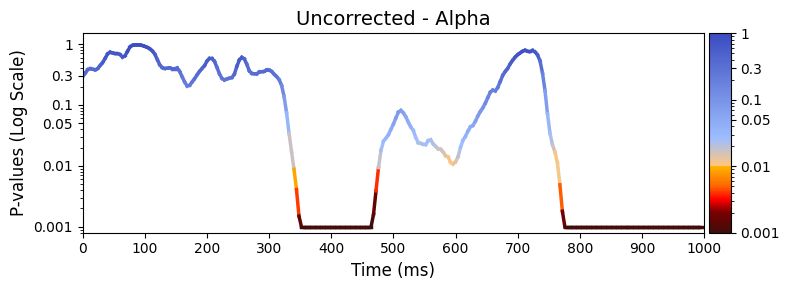

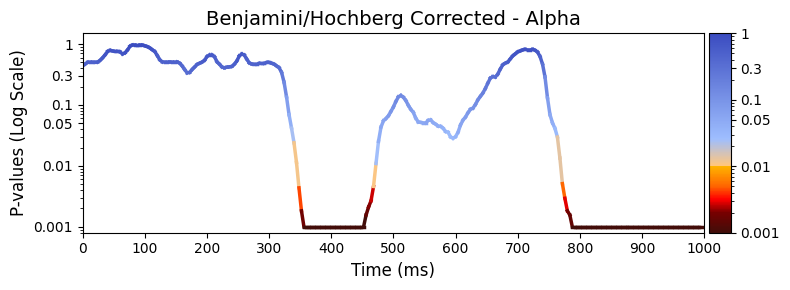

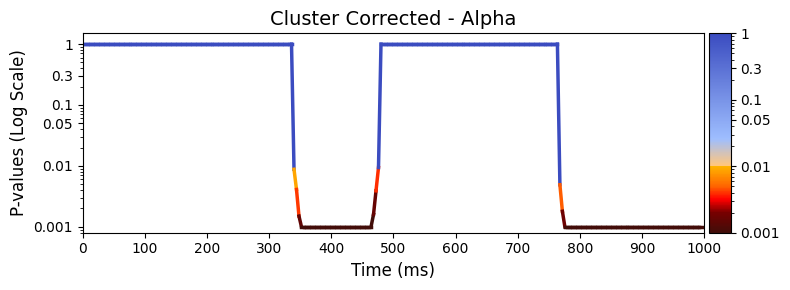

In [34]:
# Set up parameters
xlabel = "Time (ms)"
x_tick_min = 0
x_tick_max = 1000
num_x_ticks = 11
alpha = 0.01

# Plot uncorrected p-values
graphics.plot_p_values_over_time(
    results_multivariate["pval"],
    title_text=f"Uncorrected - {band_name.capitalize()}",
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha = alpha,
    save_path= PATH_FIGURES /"2_multi_uncorrected.pdf"
)

# Plot Benjamini/Hochberg corrected p-values
graphics.plot_p_values_over_time(
    pval_fdr_bh,
    title_text=f"Benjamini/Hochberg Corrected - {band_name.capitalize()}",
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha=alpha,
    save_path= PATH_FIGURES /"2_multi_fdr_bh.pdf"
)    

# Plot cluster corrected p-values
graphics.plot_p_values_over_time(
    pval_cluster,
    title_text=f"Cluster Corrected - {band_name.capitalize()}",
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha=alpha,
    save_path= PATH_FIGURES /"2_multi_cluster.pdf"
)

We can now compare if the results from ```result_multivariate_trials["pval"]``` correspond to the difference for each state over time for the two conditions. We will perform this by using the function ```plot_condition_difference```.

We will also highlight where the differences are statistically significant using the `detect_significant_intervals` function. This function takes the corrected p-values (`pval_cluster`) and the significance threshold (`alpha`) as inputs.

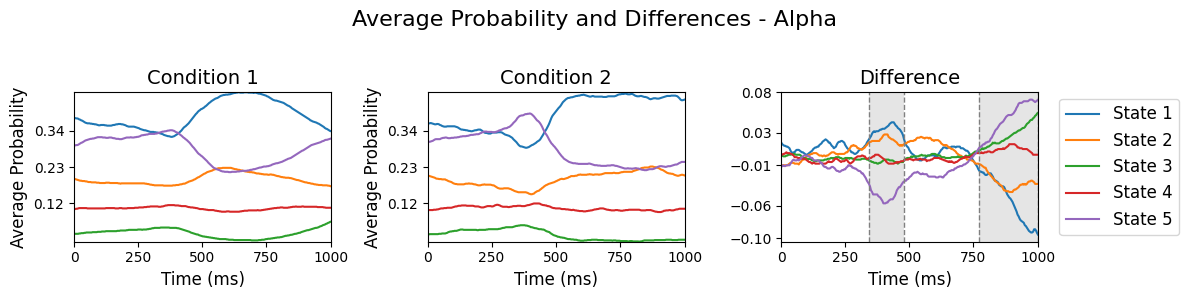

In [33]:
# Detect intervals of significance 
intervals = statistics.detect_significant_intervals(pval_cluster, alpha)

# Plot the average probability for each state over time for the two conditions and their difference.
graphics.plot_condition_difference(
    gamma_epoch, 
    R_data_epoch, 
    figsize=(12,3), 
    title=f"Average Probability and Differences - {band_name.capitalize()}",
    vertical_lines=intervals, 
    highlight_boxes=True, 
    x_tick_min=x_tick_min, 
    x_tick_max=x_tick_max, 
    xlabel="Time (ms)",
    save_path=PATH_FIGURES / "2_avg_diff.pdf"
    )

#### Conclusion - Multivariate

The multivariate analysis revealed significant time windows where the combined brain state time courses differ between conditions (animate vs. inanimate stimuli). By considering all brain states together, this approach highlights **when** the brain processes the two types of stimuli differently after cluster correction.

In the alpha band (8–13 Hz), significant differences were observed at:
* 340-476 ms
* 768-996 ms

These time windows may represent distinct phases of visual and cognitive processing.

### Step 7. Univariate Test <a id="uni_test"></a>
The univariate test examines the relationship between individual brain states ($D$, represented by ```Gamma_epoch```) and the behavioural condition ($R$, represented by ```R_data_epoch```) across sessions. Unlike the multivariate test, which considers the combined effect of all brain states, the univariate approach analyses each state separately. This allows us to pinpoint specific brain states that differ between conditions (animate vs. inanimate stimuli).  

In the context of across-trials testing, the univariate test can identify:  
- **Which brain states** show significant differences in activity across trials.  
- **When** these differences occur during the task.  

---

##### Inputs and Settings

To perform the univariate analysis using the `test_across_trials` function, the following inputs and settings are defined:

**Inputs:**
* ```D_data```: The state time courses of the brain data (```gamma_epoch```).
* ```R_data```: The experimental conditions or subject actions (```R_data_epoch```).
* ```idx_data``` : Indices for the first and last trial for a given session (```idx_data_epoch```)

**Settings:**
* ```method = "univariate"```: Specifies that the test should perform univariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).
---

##### Run the ```test_across_trials``` function
We will store the results in a dictionary called `results_univariate`, which will hold the outputs for the selected frequency band.



In [19]:
# Set parameters for univariate testing
method = "univariate"
Nperm = 10_000 # Number of permutations

results_univariate = statistics.test_across_trials(
    D_data=gamma_epoch,
    R_data=R_data_epoch,
    idx_data=idx_data_epoch,
    method=method,
    Nperm=Nperm,
)

performing permutation testing per timepoint


100%|██████████| 250/250 [30:36<00:00,  7.34s/it]


The output structure of `result_univariate` is the same as for the multivariate test and will not be repeated here.

#### Step 8. Multiple Comparison - Univariate <a id="uni_corr"></a>
To reduce the risk of false positives (type I errors), it is important to account for multiple comparisons. To handle this, we apply two types of corrections to the p-values from the `results_univariate` output:

* Benjamini/Hochberg Correction: This method adjusts p-values to control for false discovery rates. This uses the `pval_correction` function, which offers various correction methods based on *statsmodels* multitest module.

* Cluster-Based Correction: Time points are not independent from each other. This allows for a less conservative approach for correction. This method identifies clusters of significant results, doing the correction at the cluster level. Since each brain state is independent, we set `individual_features=True` to apply the correction separately for each state. We focus on p-values below a threshold of 0.01 by setting `alpha=0.01`. This is implemented using the `pval_cluster_based_correction` function.



In [35]:
# Apply Benjamini/Hochberg correction to multivariate p-values
pval_fdr_bh, _ = statistics.pval_correction(
        results_univariate, method='fdr_bh'
    )

# Apply cluster-based correction to multivariate p-values
alpha = 0.01  # Significance threshold

pval_cluster = statistics.pval_cluster_based_correction(
    results_univariate,
    alpha=alpha,
    individual_feature=True
)

#### Step 9. P-value plots - Univariate <a id="uni_corr2"></a>
With both uncorrected and corrected p-values calculated, we can now visualise them using the `plot_p_value_matrix` function.\
This shows how p-values change over time (within the trial) for each condition.
For the univariate test, the p-values are stored as an array with the shape `[number of time points, p, q]`, where $p$=5 (representing 5 states), and $q$=1 (one contrast, animate-vs-inanimate).

In our case, the p-value array has the shape (250, 5), as the data spans 250 time points per trial and 5 states.\
Since the stimulus presentation starts at 0 seconds and ends after 1000 ms, we will set the x-axis limits to:
* `x_tick_min = 0`
* `x_tick_max = 1000`

And we will be focusing on p-values below a threshold of 0.01
* `alpha = 0.01`

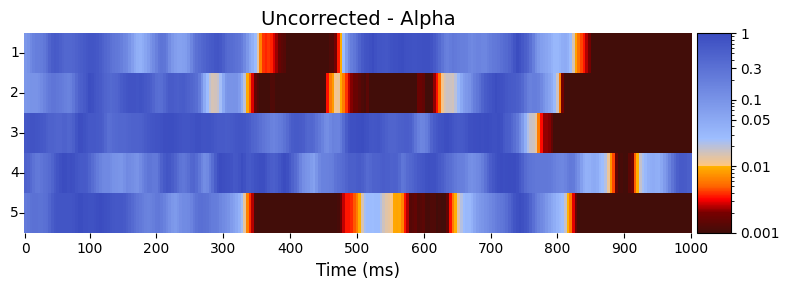

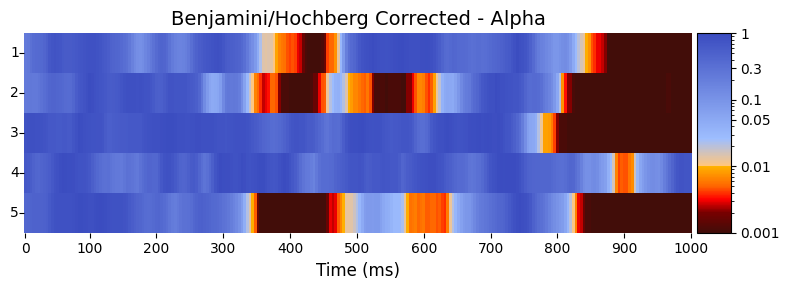

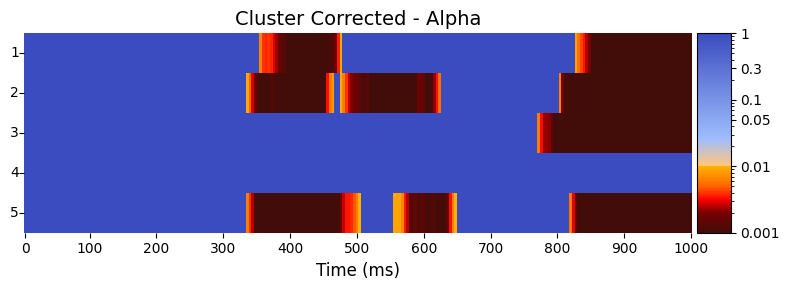

In [37]:
# Set up parameters
figsize = (8, 3)  # Adjust figure size to accommodate multiple subplots
xlabel = "Time (ms)"
x_tick_min = 0
x_tick_max = 1000
num_x_ticks = 11
alpha = 0.01


# Plot uncorrected p-values
graphics.plot_p_value_matrix(
    results_univariate["pval"].T,
    title_text=f"Uncorrected - {band_name.capitalize()}",
    figsize =figsize,
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha = alpha,
    save_path= PATH_FIGURES / "2_uni_uncorrected.pdf"
)

# Plot Benjamini/Hochberg corrected p-values
graphics.plot_p_value_matrix(
    pval_fdr_bh.T,
    title_text=f"Benjamini/Hochberg Corrected - {band_name.capitalize()}",
    figsize =figsize,
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha=alpha,
    save_path= PATH_FIGURES / "2_uni_fdr_bh.pdf"
) 

# Plot cluster-based corrected p-values
graphics.plot_p_value_matrix(
    pval_cluster.T,
    title_text=f"Cluster Corrected - {band_name.capitalize()}",
    figsize =figsize,
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha=alpha,
    save_path= PATH_FIGURES / "2_uni_cluster.pdf"
)

#### Conclusion - Univariate

The univariate analysis identified significant time windows where the activation of individual brain states differ between conditions (animate vs. inanimate stimuli). 

In the alpha band (8–13 Hz), significant differences were observed at:
* 350–650 ms across States 1,2 and 5
* 800–1000 ms in most states, except for States 4

The mid-trial period (350–650 ms) may relate to sustained processing and attention. Late-phase significance (800–1000 ms) could indicate sensory processing or memory integration as the brain distinguishes between animate and inanimate objects.

Overall, the univariate test provides a state-by-state view of how brain activity in the occipital lobe evolves over time.

### Extra - FWER Correction <a id="uni_test3"></a>
We can also perform FWER correction using the MaxT method directly by setting `FWER_correction=True`. However, we can also apply FWER correction using the function`pval_FWER_correction`

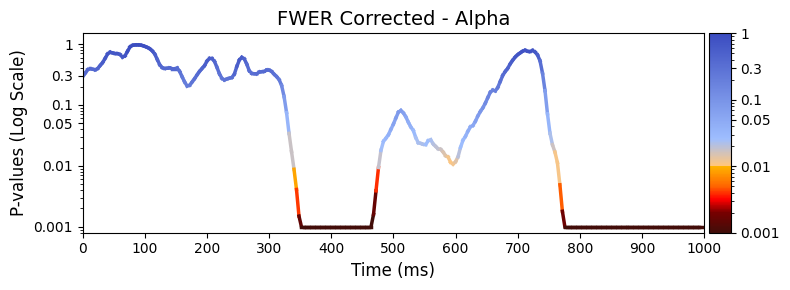

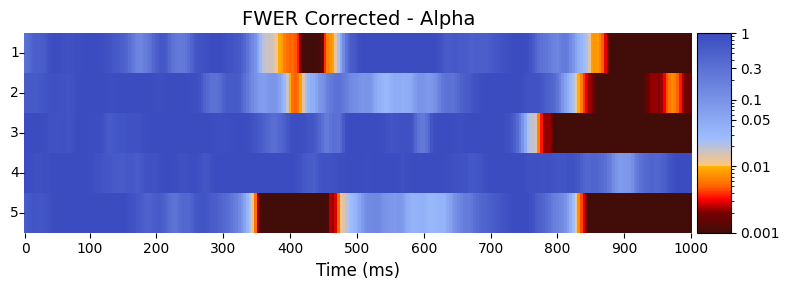

In [46]:
# Correct for FWER
pval_multivariate_FWER =statistics.pval_FWER_correction(results_multivariate)
pval_univariate_FWER =statistics.pval_FWER_correction(results_univariate)

# Plot FWER coorected p-values
graphics.plot_p_values_over_time(
    pval_multivariate_FWER,
    title_text=f"FWER Corrected - {band_name.capitalize()}",
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha = alpha,
    save_path= PATH_FIGURES / "2_multi_FWER.pdf"
    )

# Plot FWER coorected p-values
graphics.plot_p_value_matrix(
    pval_univariate_FWER.T,
    title_text=f"FWER Corrected - {band_name.capitalize()}",
    figsize =figsize,
    xlabel=xlabel,
    x_tick_min=x_tick_min,
    x_tick_max=x_tick_max,
    num_x_ticks=num_x_ticks,
    alpha = alpha,
    save_path= PATH_FIGURES / "2_uni_FWER.pdf"
)